Compare the effect of data imputation on the classification problem.

A simple dataset with numerical features and binary target is used. To estimate the effect, we censor part of the data, implement various techniques to fill in the blanks, then compare classification metrics.

# Imports and settings

In [4]:
from datetime import datetime
import numpy as np
import pandas as pd
# from tqdm import trange

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Obtain data

Prediction of diabetes among patients.

NOTE: All patients are females at least 21 years old. See the link for more.

Data taken from the open dataset:
https://www.openml.org/search?type=data&sort=runs&status=active&id=37

In [ ]:
from sklearn.datasets import fetch_openml

# Description:
# 
# Number of times pregnant
# Plasma glucose concentration a 2 hours in an oral glucose tolerance test
# Diastolic blood pressure (mm Hg)
# Triceps skin fold thickness (mm)
# 2-Hour serum insulin (mu U/ml)
# Body mass index (weight in kg/(height in m)^2)
# Diabetes pedigree function
# Age (years)

# fetch raw data
data = fetch_openml(data_id=37, parser='pandas')

df_features = data.data
display(df_features.head())

df_target = data.target
display(df_target.head())


# EDA

In [ ]:
# description

df_features.describe()

In [ ]:
sns.pairplot(df_features)
plt.show()

In [ ]:
df_target.value_counts()

# Prepare data and train-test split

In [182]:
seed = 0
rs = np.random.RandomState(seed)

In [184]:
X = df_features.copy()
y = np.where(df_target.values == 'tested_positive', 1, 0)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [188]:
transformer_x = PowerTransformer()
transformer_x.fit(X_train)

X_train = transformer_x.transform(X_train)
X_test  = transformer_x.transform(X_test)

In [ ]:
x = pd.DataFrame(data=X_train, columns=df_features.columns)

sns.pairplot(x)
plt.show()

In [ ]:
x = pd.DataFrame(data=X_test, columns=df_features.columns)

sns.pairplot(x)
plt.show()

Feature distributions are closer to normal after Yeo-Johnson transform

# Learning pipeline

In [195]:
def get_clf_metric(X_train, X_test, y_train, y_test, **kwargs):

    model = RandomForestClassifier(**kwargs)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_test)[:,1]
    
    return metrics.roc_auc_score(y_test, y_pred)

In [196]:
clf_options = {
    'n_estimators' : np.nan,
    'random_state' : seed
}

for n in range(5, 60, 5):
    clf_options['n_estimators'] = n
    print('n : ', n)
    print('Metric : ', get_clf_metric(X_train, X_test, y_train, y_test, **clf_options))

n :  5
Metric :  0.7573592700981235
n :  10
Metric :  0.7942416939232226
n :  15
Metric :  0.800438974005853
n :  20
Metric :  0.80194525735927
n :  25
Metric :  0.8090893441211913
n :  30
Metric :  0.8170080908934413
n :  35
Metric :  0.82570149767602
n :  40
Metric :  0.8326734377689792
n :  45
Metric :  0.8296608710621449
n :  50
Metric :  0.8302633844035118
n :  55
Metric :  0.829746944396626


n_estimators = 40 is well enough. Fix it throughout the research to skip CV.

In [198]:
clf_options = {
    'n_estimators' : 40,
    'random_state' : seed
}

In [199]:
benchmark_metric = get_clf_metric(X_train, X_test, y_train, y_test, **clf_options)
print('benchmark_metric : ', benchmark_metric)

benchmark_metric :  0.8326734377689792


# Censoring and imputation algorithms

In [180]:
def mcar_censor(X, rate, rs):
    return np.where(rs.rand(*X.shape) < rate, np.nan, X)

# The effect of imputation

In [323]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import Ridge, BayesianRidge

imputers = {
    'simple mean' : SimpleImputer(strategy='mean'),
    'simple median' : SimpleImputer(strategy='median'),
    'simple mode' : SimpleImputer(strategy='most_frequent'),
    'KNN': KNNImputer(n_neighbors=5),
    'Ridge' : IterativeImputer(estimator=Ridge(alpha=1e2), random_state=seed, max_iter=25, tol=1e-2)
}

In [343]:
from sklearn.pipeline import FeatureUnion
from sklearn.impute import MissingIndicator


def append_row(df, row_dict):
    d = dict([(k, [v]) for k,v in row_dict.items()])
    return pd.concat([df, pd.DataFrame(d)], ignore_index=True)
    

censor_rates = np.linspace(0, 0.9, 10)

N_ITER = 20

df_metric = pd.DataFrame()

for imp_label, imputer_ in imputers.items():
    print(imp_label)

    imputer = FeatureUnion(
        transformer_list=[
            ('imputed', imputer_),
            ('indicators', MissingIndicator())
        ]
    )
    
    for rate in censor_rates:

        for iter in range(N_ITER):

            X_train_censored = mcar_censor(X_train, rate, rs)
            X_test_censored  = mcar_censor(X_test,  rate, rs)
            
            imputer.fit(X_train_censored)
            
            X_train_imputed = imputer.transform(X_train_censored)
            X_test_imputed  = imputer.transform(X_test_censored)
            
            metric = get_clf_metric(X_train_imputed, X_test_imputed, y_train, y_test, **options)
    
            new_row = {
                'imputer' : imp_label,
                'censor_rate' : rate,
                'iteration' : iter,
                'metric' : metric
            }
            df_metric = append_row(df_metric, new_row)
        

simple mean
simple median
simple mode
KNN
Ridge


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not 

In [345]:
df_pivoted = df_metric.pivot_table(index='censor_rate', columns='imputer', values='metric', aggfunc='mean')

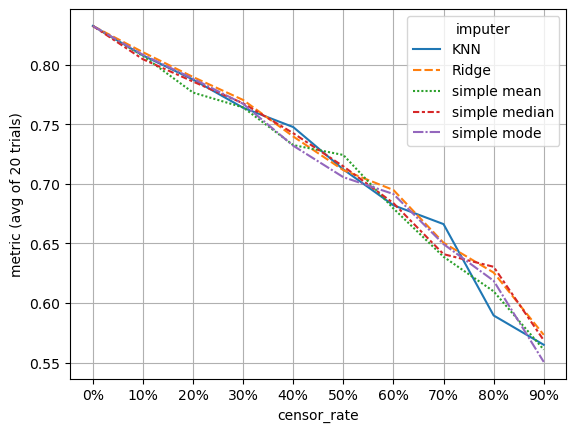

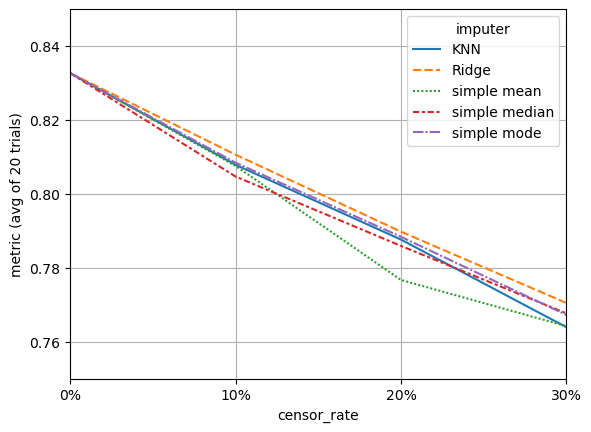

In [347]:
sns.lineplot(data=df_pivoted)

plt.xticks(df_pivoted.index, ['{0:.0f}%'.format(100*s) for s in df_pivoted.index])
plt.grid(visible=True)
plt.ylabel(f'metric (avg of {N_ITER} trials)')
plt.show()

sns.lineplot(data=df_pivoted)

plt.xticks(df_pivoted.index, ['{0:.0f}%'.format(100*s) for s in df_pivoted.index])
plt.grid(visible=True)
plt.ylabel(f'metric (avg of {N_ITER} trials)')
plt.xlim([0, 0.3])
plt.ylim([0.75, 0.85])
plt.show()